# Quantum Espresso Energy Volume Curve Workflow with aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
@task.pythonjob()
def pickle_node(value):
    """Handle data nodes"""
    return value

In [4]:
from quantum_espresso_workflow import generate_structures as _generate_structures
from quantum_espresso_workflow import get_bulk_structure as _get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import (
    plot_energy_volume_curve as _plot_energy_volume_curve,
)

In [5]:
strain_lst = [0.9, 0.95, 1.0, 1.05, 1.1]

In [6]:
get_bulk_structure = task.pythonjob()(_get_bulk_structure)
generate_structures = task.pythonjob()(_generate_structures)
calculate_qe = task.pythonjob(outputs=["energy", "volume", "structure"])(_calculate_qe)
plot_energy_volume_curve = task.pythonjob()(_plot_energy_volume_curve)

In [7]:
wg = WorkGraph("wg-qe")

## Helper tasks that just pickle input data

In [8]:
pickle_element_task = wg.add_task(
    pickle_node,
    name="pickle_element",
    value="Al",
)

In [9]:
pickle_a_task = wg.add_task(pickle_node, name="pickle_a", value=4.05)

In [10]:
pickle_cubic_task = wg.add_task(pickle_node, name="pickle_cubic", value=True)

In [11]:
pickle_relax_workdir_task = wg.add_task(
    pickle_node,
    name="pickle_relax_workdir",
    value="mini",
)

In [12]:
pickle_pp_task = wg.add_task(
    pickle_node,
    name="pseudopotentials",
    value={"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"},
)

In [13]:
pickle_kpts_task = wg.add_task(pickle_node, name="kpts_task", value=[3, 3, 3])

In [14]:
pickle_calc_type_relax_task = wg.add_task(
    pickle_node,
    name="calc_type_relax",
    value="vc-relax",
)

In [15]:
pickle_calc_type_scf_task = wg.add_task(
    pickle_node,
    name="calc_type_scf",
    value="scf",
)

In [16]:
pickle_smearing_task = wg.add_task(pickle_node, name="smearing", value=0.02)

In [17]:
pickle_strain_lst_task = wg.add_task(
    pickle_node,
    name="pickle_strain_lst",
    value=strain_lst,
)

## Actual tasks to construct the EOS workflow

In [18]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    register_pickle_by_value=True,
    element=pickle_element_task.outputs.result,
    a=pickle_a_task.outputs.result,
    cubic=pickle_cubic_task.outputs.result,
)

In [19]:
relax_prepare_input_dict_task = wg.add_task(
    task.pythonjob()(get_dict),
    name="relax_get_dict",
    register_pickle_by_value=True,
    structure=get_bulk_structure_task.outputs.result,
    calculation=pickle_calc_type_relax_task.outputs.result,
    kpts=pickle_kpts_task.outputs.result,
    pseudopotentials=pickle_pp_task.outputs.result,
    smearing=pickle_smearing_task.outputs.result,
)

relax_task = wg.add_task(
    calculate_qe,
    name="mini",
    register_pickle_by_value=True,
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=pickle_relax_workdir_task.outputs.result,
)

In [20]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    register_pickle_by_value=True,
    structure=relax_task.outputs.structure,
    strain_lst=pickle_strain_lst_task.outputs.result,
)

In [21]:
get_volumes_task = wg.add_task(
    task.pythonjob()(get_list),
    name="get_volumes",
    register_pickle_by_value=True,
)

In [22]:
get_energies_task = wg.add_task(
    task.pythonjob()(get_list),
    name="get_energies",
    register_pickle_by_value=True,
)

In [23]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = f"strain_{i}"
    generate_structures_task.add_output("workgraph.any", structure_key)

    strain_dir_task = wg.add_task(
        pickle_node,
        name=f"pickle_{strain_dir}_dir",
        value=strain_dir,
        register_pickle_by_value=True,
    )

    scf_prepare_input_dict_task = wg.add_task(
        task.pythonjob()(get_dict),
        name=f"get_dict_{i}",
        register_pickle_by_value=True,
        structure=generate_structures_task.outputs[structure_key],
        calculation=pickle_calc_type_scf_task.outputs.result,
        kpts=pickle_kpts_task.outputs.result,
        pseudopotentials=pickle_pp_task.outputs.result,
        smearing=pickle_smearing_task.outputs.result,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        register_pickle_by_value=True,
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir_task.outputs.result,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [24]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    register_pickle_by_value=True,
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [25]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [26]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [27]:
!cat {workflow_json_filename}

{
  "nodes": {
    "0": "Al",
    "1": 4.05,
    "2": true,
    "3": "mini",
    "4": {
      "Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"
    },
    "5": [
      3,
      3,
      3
    ],
    "6": "vc-relax",
    "7": "scf",
    "8": 0.02,
    "9": [
      0.9,
      0.95,
      1.0,
      1.05,
      1.1
    ],
    "10": "quantum_espresso_workflow.get_bulk_structure",
    "11": "python_workflow_definition.shared.get_dict",
    "12": "quantum_espresso_workflow.calculate_qe",
    "13": "quantum_espresso_workflow.generate_structures",
    "14": "python_workflow_definition.shared.get_list",
    "15": "python_workflow_definition.shared.get_list",
    "16": "strain_0",
    "17": "python_workflow_definition.shared.get_dict",
    "18": "quantum_espresso_workflow.calculate_qe",
    "19": "strain_1",
    "20": "python_workflow_definition.shared.get_dict",
    "21": "quantum_espresso_workflow.calculate_qe",
    "22": "strain_2",
    "23": "python_workflow_definition.shared.get_dict",
    "24": "quantu

## Load Workflow with jobflow

In [28]:
from python_workflow_definition.jobflow import load_workflow_json

/home/jan/mambaforge/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/home/jan/mambaforge/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [29]:
from jobflow.managers.local import run_locally

In [30]:
flow = load_workflow_json(file_name=workflow_json_filename)

2025-03-27 18:03:30,952 INFO Started executing jobs locally
2025-03-27 18:03:34,071 INFO Starting job - get_bulk_structure (9f8dfd72-24c3-4c94-a92a-9b7c6923cdf0)
2025-03-27 18:03:34,184 INFO Finished job - get_bulk_structure (9f8dfd72-24c3-4c94-a92a-9b7c6923cdf0)
2025-03-27 18:03:34,186 INFO Starting job - get_dict (42b70db9-a867-4960-9c9c-0245f9af45a3)
2025-03-27 18:03:34,192 INFO Finished job - get_dict (42b70db9-a867-4960-9c9c-0245f9af45a3)
2025-03-27 18:03:34,193 INFO Starting job - calculate_qe (a8ea4e49-953b-44ec-ab13-017b5e79bce1)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-27 18:04:04,205 INFO Finished job - calculate_qe (a8ea4e49-953b-44ec-ab13-017b5e79bce1)
2025-03-27 18:04:04,207 INFO Starting job - generate_structures (abd9ed28-f79f-4ca7-a7d8-ffa3a8ab220c)
2025-03-27 18:04:04,224 INFO Finished job - generate_structures (abd9ed28-f79f-4ca7-a7d8-ffa3a8ab220c)
2025-03-27 18:04:04,225 INFO Starting job - get_dict (b0c375fc-2ef6-4d8a-92bf-101d1a96ec41)
2025-03-27 18:04:04,231 INFO Finished job - get_dict (b0c375fc-2ef6-4d8a-92bf-101d1a96ec41)
2025-03-27 18:04:04,232 INFO Starting job - get_dict (16622299-f437-4888-b102-17566177b819)
2025-03-27 18:04:04,235 INFO Finished job - get_dict (16622299-f437-4888-b102-17566177b819)
2025-03-27 18:04:04,236 INFO Starting job - get_dict (dd312bf3-95a0-4aa3-80b1-8dfbf0f8be32)
2025-03-27 18:04:04,240 INFO Finished job - get_dict (dd312bf3-95a0-4aa3-80b1-8dfbf0f8be32)
2025-03-27 18:04:04,241 INFO Starting job - get_dict (e00200ec-8812-49e7-98f3-4a463525bcf6)
2025-03-27 18:04:04,245 INFO Finished job - get_dict (

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-27 18:04:09,363 INFO Finished job - calculate_qe (db3d85c8-9b4a-42a9-96fc-a9f10c911aba)
2025-03-27 18:04:09,364 INFO Starting job - calculate_qe (1d25e020-58df-42b6-bcd5-590d0dd0e9c1)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-27 18:04:14,741 INFO Finished job - calculate_qe (1d25e020-58df-42b6-bcd5-590d0dd0e9c1)
2025-03-27 18:04:14,742 INFO Starting job - calculate_qe (d3243e45-74c7-498b-9f79-04501bdd4fb5)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-27 18:04:20,629 INFO Finished job - calculate_qe (d3243e45-74c7-498b-9f79-04501bdd4fb5)
2025-03-27 18:04:20,629 INFO Starting job - calculate_qe (b0ffcaf7-fe05-4de1-bf20-4d385ba3fafb)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-27 18:04:27,214 INFO Finished job - calculate_qe (b0ffcaf7-fe05-4de1-bf20-4d385ba3fafb)
2025-03-27 18:04:27,215 INFO Starting job - calculate_qe (6c79afc9-8616-49c9-898b-fd2a195a1530)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-03-27 18:04:33,937 INFO Finished job - calculate_qe (6c79afc9-8616-49c9-898b-fd2a195a1530)
2025-03-27 18:04:33,938 INFO Starting job - get_list (308a6451-6359-4809-8939-7051e28c786b)
2025-03-27 18:04:33,950 INFO Finished job - get_list (308a6451-6359-4809-8939-7051e28c786b)
2025-03-27 18:04:33,951 INFO Starting job - get_list (3b6e7c8d-4f9c-43b6-9185-4d45de3a7e88)
2025-03-27 18:04:33,958 INFO Finished job - get_list (3b6e7c8d-4f9c-43b6-9185-4d45de3a7e88)
2025-03-27 18:04:33,958 INFO Starting job - plot_energy_volume_curve (64b6b07b-842d-4150-a564-27a56b0bcff8)
2025-03-27 18:04:34,167 INFO Finished job - plot_energy_volume_curve (64b6b07b-842d-4150-a564-27a56b0bcff8)
2025-03-27 18:04:34,168 INFO Finished executing jobs locally


{'9f8dfd72-24c3-4c94-a92a-9b7c6923cdf0': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

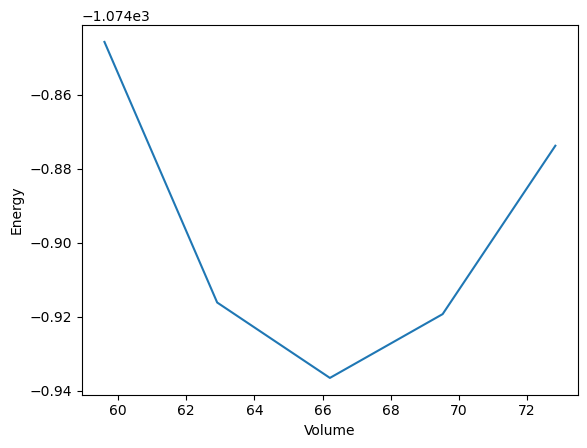

In [31]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [32]:
from pyiron_base import Project

In [33]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [34]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

  0%|          | 0/19 [00:00<?, ?it/s]

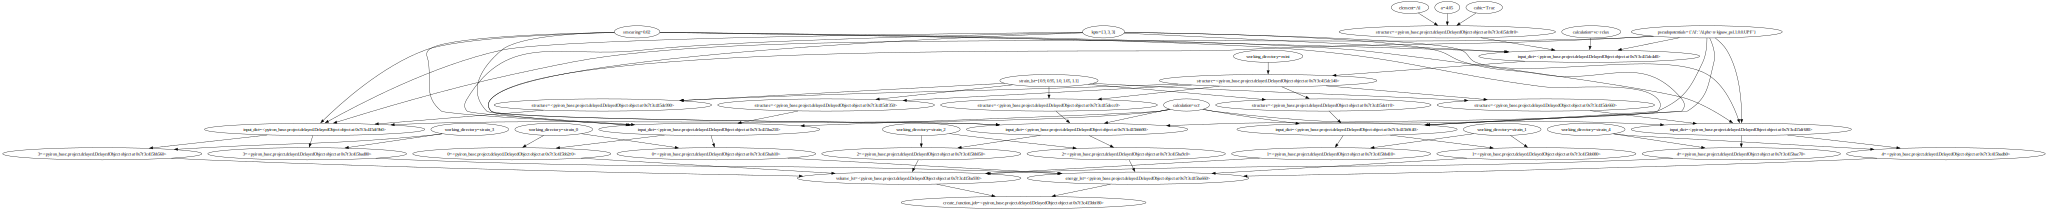

In [35]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 8
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 9
The job calculate_qe_22b5d0934d89d8f08761e744e4612c30 was saved and received the ID: 10


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_0f73111f80fee29b8afd5e14453bffa8 was saved and received the ID: 11
The job get_dict_55d1bd2244a45398056ddb1c0cbad029 was saved and received the ID: 12
The job calculate_qe_94144ffa59c45dea05dc081722e987ab was saved and received the ID: 13


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_e9594cf5881581c8ba821e2a30a48a10 was saved and received the ID: 14
The job calculate_qe_53d26f4879eb4978a253eb0aa1029113 was saved and received the ID: 15


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_252b1e4ec0c9c64d35ccf410c59b7802 was saved and received the ID: 16
The job calculate_qe_d9323bd7caaed18758b99a1807e922ce was saved and received the ID: 17


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_0f8ec8b6f1614bbd0e8535707c4d4c25 was saved and received the ID: 18
The job calculate_qe_ce328c3f81f8c32928c5d9afcef5cd03 was saved and received the ID: 19


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_ab6337f6767889e55c56e5b06f78d353 was saved and received the ID: 20
The job calculate_qe_0c7e3dd81f83bb1c9fa294a63874b4b9 was saved and received the ID: 21


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_a6df7a07656486154523680b67dc543b was saved and received the ID: 22
The job get_list_f14c9adeb16b4b1b25e9c4c2e4b0cf13 was saved and received the ID: 23
The job plot_energy_volume_curve_5dea3fa7571ea91ed1aa1745897703c7 was saved and received the ID: 24


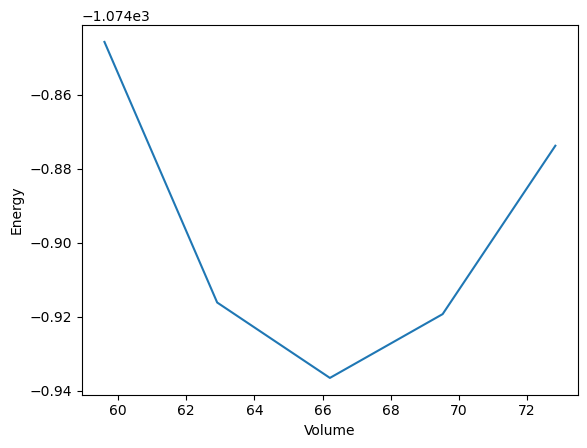

In [36]:
delayed_object.pull()